# Create the baseline

> Learn more about the data and form a good starting point for further inquiry

Here are the things we will attempt:

* predicting clan ('EC1' or 'EC2') from interclick intervals (ICI)
* predicting coda type (one out of 23 values)

So far, based on the [Deep Machine Learning Techniques for the Detection and Classification of Sperm Whale Bioacoustics](https://www.nature.com/articles/s41598-019-48909-4), we know that this is possible. This is a significant finding - maybe any attempt at learning how whales communicate should start with the ICI? For instance, could whale communication be similar to morse code with the difference that here the duration of silence encodes some portion of the meaning?

Or could the model be taking some sort of a shortcut? For predicting the clan, maybe there are obvious differences between how the clans communicate, maybe one uses sequences of different length than the other and the task of telling them apart is trivial?

As for predicting the coda type, coda type assignment is done manually. A coda consisting of 5 clicks with similar interclick intervals will be assigned some label, 5 clicks with one longer gap another, and so on. All the performance on this task is telling us, is how well our model can emulate the classification done by human annotators. This is useful for annotating large quantities of data where labeled data can be used for further analysis. At its core though, it only speaks to the ability of the model learn a mapping from ICIs to the taxonomy devised by researchers.

In any case, looking at the data will tell us more. I don't believe the analysis done here will be exhaustive (due to limited amount of data and how narrow the tasks we picked are), but hopefully it can contribute to the inquiry. 

From a machine learning perspective, starting with a simple baseline is extremely important. It is a great way to learn more about our data. Also, machine learning code is notoriously easy to get lost in, and if we don't have a baseline to refer to, we cannot be sure whether we are on the right track in building more advanced models.

Without further ado, let's look at the data.

**Sidenote**: I am having a hard time finding papers that would not be paywalled, but if you would be interesting in reading more about the topic of coda types and what meaning they can carry, here is a very good read that is availabe publicly: [Differences in sperm whale codas between two waters off Japan: Possible geographic separation of vocal clans](https://www.researchgate.net/publication/261707788_Differences_in_sperm_whale_codas_between_two_waters_off_Japan_Possible_geographic_separation_of_vocal_clans)

In [1]:
from sperm_whale_bioacoustics.data import * # this import will take quite a while, but saves us
                                            # a lot of NB real estate and typing
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
datasets_clan.items.shape

(1898, 18)

In [3]:
datasets_clan.items.head() # these are the examples we sampled in 02_Data_preparation.ipynb

,codaNUM2018,Date,nClicks,Duration,ICI1,ICI2,ICI3,ICI4,ICI5,ICI6,ICI7,ICI8,ICI9,CodaType,Clan,Unit,UnitNum,IDN
1421,1422,2010-02-12 00:00:00,7,1.431100,0.481200,0.267900,0.237700,0.176600,0.1265,0.1412,0.0,0.0,0.0,7D1,EC1,F,3,5722
2748,2749,2008-04-19 00:00:00,5,0.361000,0.117000,0.097000,0.078000,0.069000,0.0000,0.0000,0.0,0.0,0.0,5R1,EC1,R,8,0
3475,3476,2010-02-11 00:00:00,5,0.806600,0.219900,0.245700,0.161100,0.179900,0.0000,0.0000,0.0,0.0,0.0,1+1+3,EC1,U,11,6035
5665,5707,2015-03-02 00:00:00,5,0.832792,0.273092,0.257708,0.161283,0.140708,0.0000,0.0000,0.0,0.0,0.0,1+1+3,EC1,A,1,5586
3002,3003,2010-03-10 00:00:00,5,0.338000,0.085000,0.106000,0.074000,0.073000,0.0000,0.0000,0.0,0.0,0.0,5R1,EC1,T,10,0


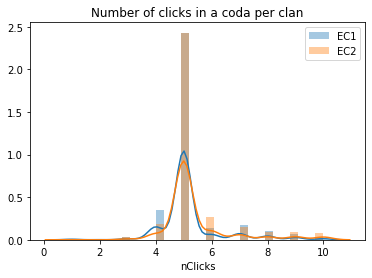

In [4]:
for clan in np.unique(datasets_clan.items.Clan):
    sns.distplot(datasets_clan.items[datasets_clan.items.Clan==clan]['nClicks'], label=clan)
plt.legend()
plt.title('Number of clicks in a coda per clan');

Nothing too obvious here - both clans seem to use codas with comparable number of clicks.

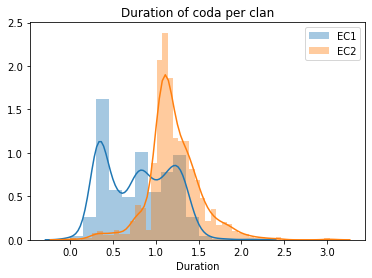

In [5]:
for clan in np.unique(datasets_clan.items.Clan):
    sns.distplot(datasets_clan.items[datasets_clan.items.Clan==clan]['Duration'], label=clan)
plt.legend();
plt.title('Duration of coda per clan');

This is a significant difference, but still not something that would make the task entirely obvious.

Let's learn a bit more about the situation and establish a baseline in the process.

In [6]:
from sklearn.linear_model import LogisticRegression

In [7]:
clf = LogisticRegression(random_state=42).fit(
    datasets_clan.items['Duration'].values[datasets_clan.splits[0]].reshape(-1, 1),
    datasets_clan.items.Clan.values[datasets_clan.splits[0]]
)

In [8]:
clf.score(
    datasets_clan.items['Duration'].values[datasets_clan.splits[1]].reshape(-1, 1),
    datasets_clan.items.Clan.values[datasets_clan.splits[1]]
)

0.7578947368421053

We are at 75.7% accuracy, but bear in mind this is with only two classes. Let's see what will happen if we consider only the ICI values.

In [9]:
clf = LogisticRegression(random_state=42).fit(
    np.concatenate((
        datasets_clan.items.iloc[:, 4:13].values[datasets_clan.splits[0]],
    ), axis=1),
    datasets_clan.items.Clan.values[datasets_clan.splits[0]]
)

In [10]:
clf.score(
    np.concatenate((
        datasets_clan.items.iloc[:, 4:13].values[datasets_clan.splits[1]],
    ), axis=1),
    datasets_clan.items.Clan.values[datasets_clan.splits[1]]
)

0.9157894736842105

91.6% accuracy. Since the ICIs are roughly of comparable length between all of the clicks, we can look at the weights to gain some understanding which ICI is more characteristic of which class (this analysis could be helped by normalizing the ICI intervals, though the results might be harder to interpret).

In [11]:
datasets_clan.items.iloc[:, 4:13].values[datasets_clan.splits[1]].max(0)

array([0.6217803, 0.6033788, 0.5930743, 0.5883212, 0.374    , 0.3137   ,
       0.2153   , 0.2893   , 0.179    ])

In [12]:
clf.coef_

array([[-3.65852064, -2.4368024 , 12.40962588,  9.34368781,  2.37773946,
         2.28864823,  1.75728995,  1.51945018,  0.89396356]])

In [13]:
clf.classes_

array(['EC1', 'EC2'], dtype=object)

This is very rudimentary but we can start to see that a hallmark of belonging to `EC2` is a longer ICI between the 3rd and the 4th click and the 4th and the 5th.

In [14]:
datasets_clan.items.iloc[np.where(datasets_clan.items.Clan == 'EC1')[0], 6].values.mean(), datasets_clan.items.iloc[np.where(datasets_clan.items.Clan == 'EC2')[0], 6].values.mean()

(0.14706728724973656, 0.27850803024236037)

In [15]:
datasets_clan.items.iloc[np.where(datasets_clan.items.Clan == 'EC1')[0], 7].values.mean(), datasets_clan.items.iloc[np.where(datasets_clan.items.Clan == 'EC2')[0], 7].values.mean()

(0.11971786322444679, 0.26639890031612223)

Let's try fitting a simple model for predicting CodaType again just on the ICI values.

In [16]:
clf = LogisticRegression(random_state=42).fit(
    np.concatenate((
        datasets_clan.items.iloc[:, 4:13].values[datasets_clan.splits[0]],
    ), axis=1),
    datasets_clan.items.CodaType.factorize()[0][datasets_clan.splits[0]]
)

In [17]:
clf.score(
    np.concatenate((
        datasets_clan.items.iloc[:, 4:13].values[datasets_clan.splits[1]],
    ), axis=1),
    datasets_clan.items.CodaType.factorize()[0][datasets_clan.splits[1]]
)

0.6894736842105263

All this gives us some insights into the data and will serve as a good baseline.

Let's now reproduce the results from the paper.